In [1]:
%matplotlib inline
# reload external modules when they change.
%load_ext autoreload  
%autoreload 2

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns # prettier plots
sns.set_style('white') # get rid of the grids

In [3]:
# Don't worry about what all these are -- used later
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [4]:
from helpers import printoptions  # make numpy printouts prettier
from display import plot_training_curves, visualize_keras_model

In [5]:
# let's build a really simple model: linear regression from 
# 2 inputs to a single float output

model = Sequential()
model.add(Dense(output_dim=1, input_dim=2))

# mean squared error regression, RMSprop optimizer
model.compile(loss='mse', optimizer='rmsprop')

/Users/shnayder/anaconda/lib/python2.7/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1, input_dim=2)`
  '` call to the Keras 2 API: ' + signature)


Let's look at our model:

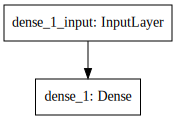

In [6]:
visualize_keras_model(model)

Let's make up some data:

$y = 3a + 5b + N(0,1)$

where the last term is normally distributed error.

In [7]:
num_samples = 100
data = np.random.random((num_samples, 2))
noise = np.random.normal(size=num_samples)
values = 3 * data[:,0] + 5 * data[:,1] + noise

In [8]:
# Look at it:
with printoptions(precision=2, threshold=20):
    print data
    print noise
    print values

[[ 0.39  0.81]
 [ 0.76  0.6 ]
 [ 0.4   0.28]
 ..., 
 [ 0.37  0.55]
 [ 0.52  0.15]
 [ 0.17  0.19]]
[-1.12 -0.9   0.96 ..., -0.94  0.2   0.42]
[ 4.11  4.41  3.59 ...,  2.91  2.52  1.91]


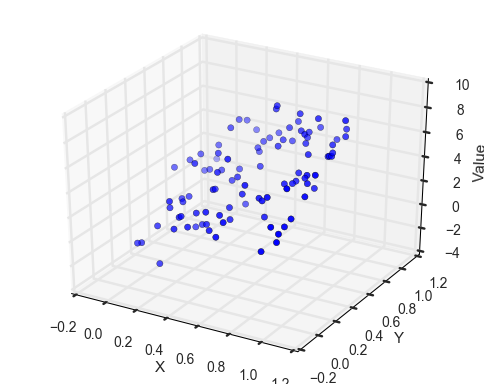

In [16]:
# and plot it 
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs=data[:,0], ys=data[:,1], zs=values)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Value')
fig.tight_layout()

We can see that (as expected) the values lie roughly in a plane, so our linear model should do a good job...

Let's fit it!

In [10]:
history = model.fit(data, values, nb_epoch=10, batch_size=32)

/Users/shnayder/anaconda/lib/python2.7/site-packages/keras/models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/10
100/100 [==============================] - 0s - loss: 19.5256     
Epoch 2/10
100/100 [==============================] - 0s - loss: 19.3920     
Epoch 3/10
100/100 [==============================] - 0s - loss: 19.2998     
Epoch 4/10
100/100 [==============================] - 0s - loss: 19.2241     
Epoch 5/10
100/100 [==============================] - 0s - loss: 19.1430     
Epoch 6/10
100/100 [==============================] - 0s - loss: 19.0757     
Epoch 7/10
100/100 [==============================] - 0s - loss: 19.0038     
Epoch 8/10
100/100 [==============================] - 0s - loss: 18.9388     
Epoch 9/10
100/100 [==============================] - 0s - loss: 18.8813     
Epoch 10/10
100/100 [==============================] - 0s - loss: 18.8231     


In [14]:
# the history object keeps track of the loss (and other metrics if we have them)
history.history

{'loss': [19.525561523437499,
  19.391978149414062,
  19.299752044677735,
  19.22406951904297,
  19.143045730590821,
  19.07572380065918,
  19.003786621093749,
  18.938757610321044,
  18.881260433197021,
  18.823107109069824]}

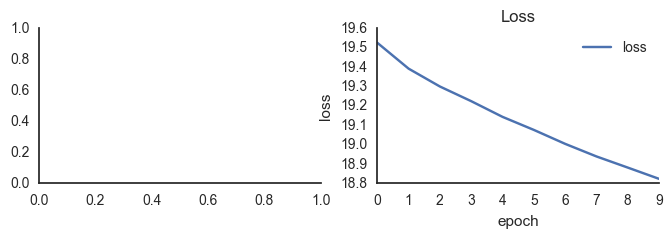

In [23]:
# A handy function to plot
plot_training_curves(history.history);

Error still high and dropping. Let's keep fitting for a long time -- it's fast.

In [18]:
history = model.fit(data, values, nb_epoch=1000, batch_size=32, verbose=0)

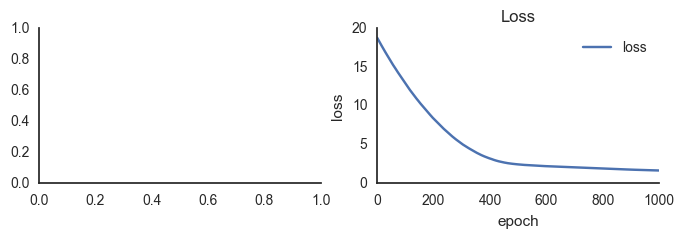

In [22]:
plot_training_curves(history.history);

Let's see how it's doing.

In [25]:
help(model.evaluate)

Help on method evaluate in module keras.models:

evaluate(self, x, y, batch_size=32, verbose=1, sample_weight=None) method of keras.models.Sequential instance
    Computes the loss on some input data, batch by batch.
    
    # Arguments
        x: input data, as a Numpy array or list of Numpy arrays
            (if the model has multiple inputs).
        y: labels, as a Numpy array.
        batch_size: integer. Number of samples per gradient update.
        verbose: verbosity mode, 0 or 1.
        sample_weight: sample weights, as a Numpy array.
    
    # Returns
        Scalar test loss (if the model has no metrics)
        or list of scalars (if the model computes other metrics).
        The attribute `model.metrics_names` will give you
        the display labels for the scalar outputs.
    
    # Raises
        RuntimeError: if the model was never compiled.



In [26]:
model.evaluate(data, values, batch_size=32)

 32/100 [========>.....................] - ETA: 0s

1.6559569525718689

And now we can look at the weights -- since it's a tiny linear model we can look at them directly.

In [27]:
model.get_weights()

[array([[ 2.51010251],
        [ 2.65982103]], dtype=float32), array([ 1.34036446], dtype=float32)]

So it's learned a model of $2.5a + 2.65b + 1.3$. Not quite right.

Let's save the learned weights and use our "known" weights instead to see how they do.

In [28]:
saved_weights = model.get_weights()
model.set_weights([np.array([[3], [5]]), np.array([0])])
model.evaluate(data, values)

 32/100 [========>.....................] - ETA: 0s

1.1781642735004425

In [29]:
# What is this loss value? We said loss='mse' above. Let's check that...

deltas = values - (3 * data[:,0] + 5 * data[:,1])  # i.e. the noise
squared_deltas = np.square(deltas)
np.mean(squared_deltas)

1.1781643409145459

So, it is indeed what we told Keras to use: MSE, or Mean Squared Error

So, why did it take so long to learn? Because the learning rate is low, and the variable initialization isn't very good for our problem.

Let's try to tweak the optimizer:

In [38]:
model2 = Sequential()
model2.add(Dense(output_dim=1, input_dim=2))

# the default learning rate we used above is 0.001, so this is 100 times higher.
optimizer = RMSprop(lr=0.1)
model2.compile(loss='mse', optimizer=optimizer)

In [39]:
history = model2.fit(data, values, nb_epoch=10, batch_size=32)

Epoch 1/10
100/100 [==============================] - 0s - loss: 19.8732     
Epoch 2/10
100/100 [==============================] - 0s - loss: 9.8419     
Epoch 3/10
100/100 [==============================] - 0s - loss: 5.7851     
Epoch 4/10
100/100 [==============================] - 0s - loss: 4.0555     
Epoch 5/10
100/100 [==============================] - 0s - loss: 3.0020     
Epoch 6/10
100/100 [==============================] - 0s - loss: 2.5632     
Epoch 7/10
100/100 [==============================] - 0s - loss: 2.3587     
Epoch 8/10
100/100 [==============================] - 0s - loss: 2.2296     
Epoch 9/10
100/100 [==============================] - 0s - loss: 2.1575     
Epoch 10/10
100/100 [==============================] - 0s - loss: 2.0879     


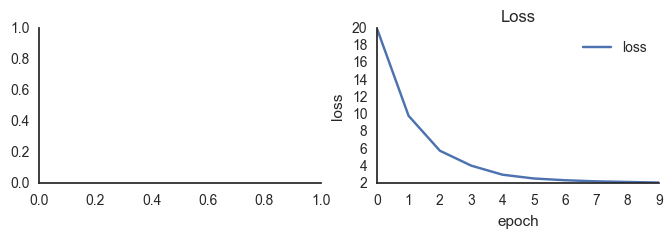

In [40]:
plot_training_curves(history.history);

Aha -- higher learning rate certainly helps. Could also fiddle with initialization values: let's "cheat" and give it the exact "correct" values.

In [35]:
model3 = Sequential()
model3.add(Dense(output_dim=1, input_dim=2, 
                 weights=[np.array([[3],[5]]), np.array([0])]))

# reduced LR from model2 so it doesn't bounce around as much
optimizer = RMSprop(lr=0.01)  
model3.compile(loss='mse', optimizer=optimizer)

/Users/shnayder/anaconda/lib/python2.7/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1, weights=[array([[3..., input_dim=2)`
  '` call to the Keras 2 API: ' + signature)


In [36]:
model3.evaluate(data, values, batch_size=32)

 32/100 [========>.....................] - ETA: 0s

1.1781642735004425

In [37]:
model3.fit(data, values, nb_epoch=10, batch_size=32)

Epoch 1/10
100/100 [==============================] - 0s - loss: 1.1700     
Epoch 2/10
100/100 [==============================] - 0s - loss: 1.1569     
Epoch 3/10
100/100 [==============================] - 0s - loss: 1.1520     
Epoch 4/10
100/100 [==============================] - 0s - loss: 1.1471     
Epoch 5/10
100/100 [==============================] - 0s - loss: 1.1427     
Epoch 6/10
100/100 [==============================] - 0s - loss: 1.1466     
Epoch 7/10
100/100 [==============================] - 0s - loss: 1.1418     
Epoch 8/10
100/100 [==============================] - 0s - loss: 1.1377     
Epoch 9/10
100/100 [==============================] - 0s - loss: 1.1356     
Epoch 10/10
100/100 [==============================] - 0s - loss: 1.1376     


Interesting: we started with the "correct" parameters used to generate the data, but the network keeps "learning" and getting lower training error. So even with just two parameters, we can _overfit_, get distracted by the noise. Validation sets will help... in a future notebook.